## **Data en internet**

# Análisis Exploratorio de Datos - **Proyecto del Titanic**
## ➡️ Uriel Emiliano Mendez

Este proyecto consiste en la predicción de la supervivencia de los pasajeros del Titanic utilizando técnicas de Machine Learning. Utilizando el conjunto de datos disponible en Kaggle, he aplicado diversas estrategias de análisis, limpieza de datos y modelos de clasificación para predecir quién sobrevivió al naufragio. El objetivo es mejorar la precisión de las predicciones y optimizar los modelos a través de enfoques como GridSearchCV, validación cruzada y selección de características.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set()

In [30]:
# Visual Studio Code
df_main = pd.read_csv('../datasets/Titanic-Dataset.csv')
df_ext = pd.read_csv('../datasets/Titanic-Dataset-Extendido.csv')

# Google colab
# from google.colab import drive
# drive.mount('/content/drive')
# df_main = pd.read_csv('/content/drive/MyDrive/IES/2º Semestre/Aprendizaje Automatico I/Notebooks/Titanic/Titanic-Dataset.csv')
# df_ext = pd.read_csv('/content/drive/MyDrive/IES/2º Semestre/Aprendizaje Automatico I/Notebooks/Titanic/Titanic-Dataset-Extendido.csv')

print(df_main.shape, df_ext.shape)

(891, 12) (891, 21)


### Pruebas empiricas 🗂️

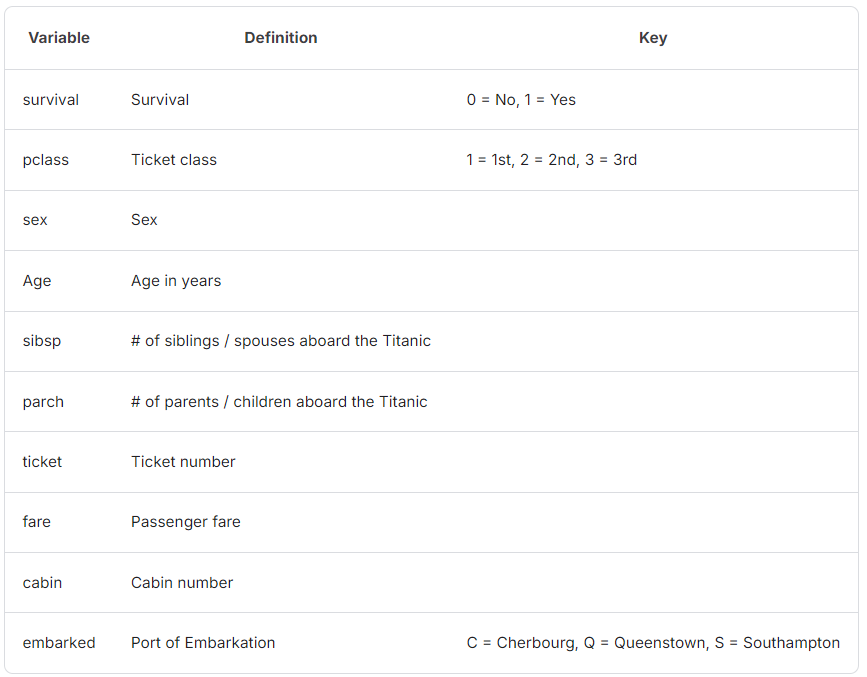

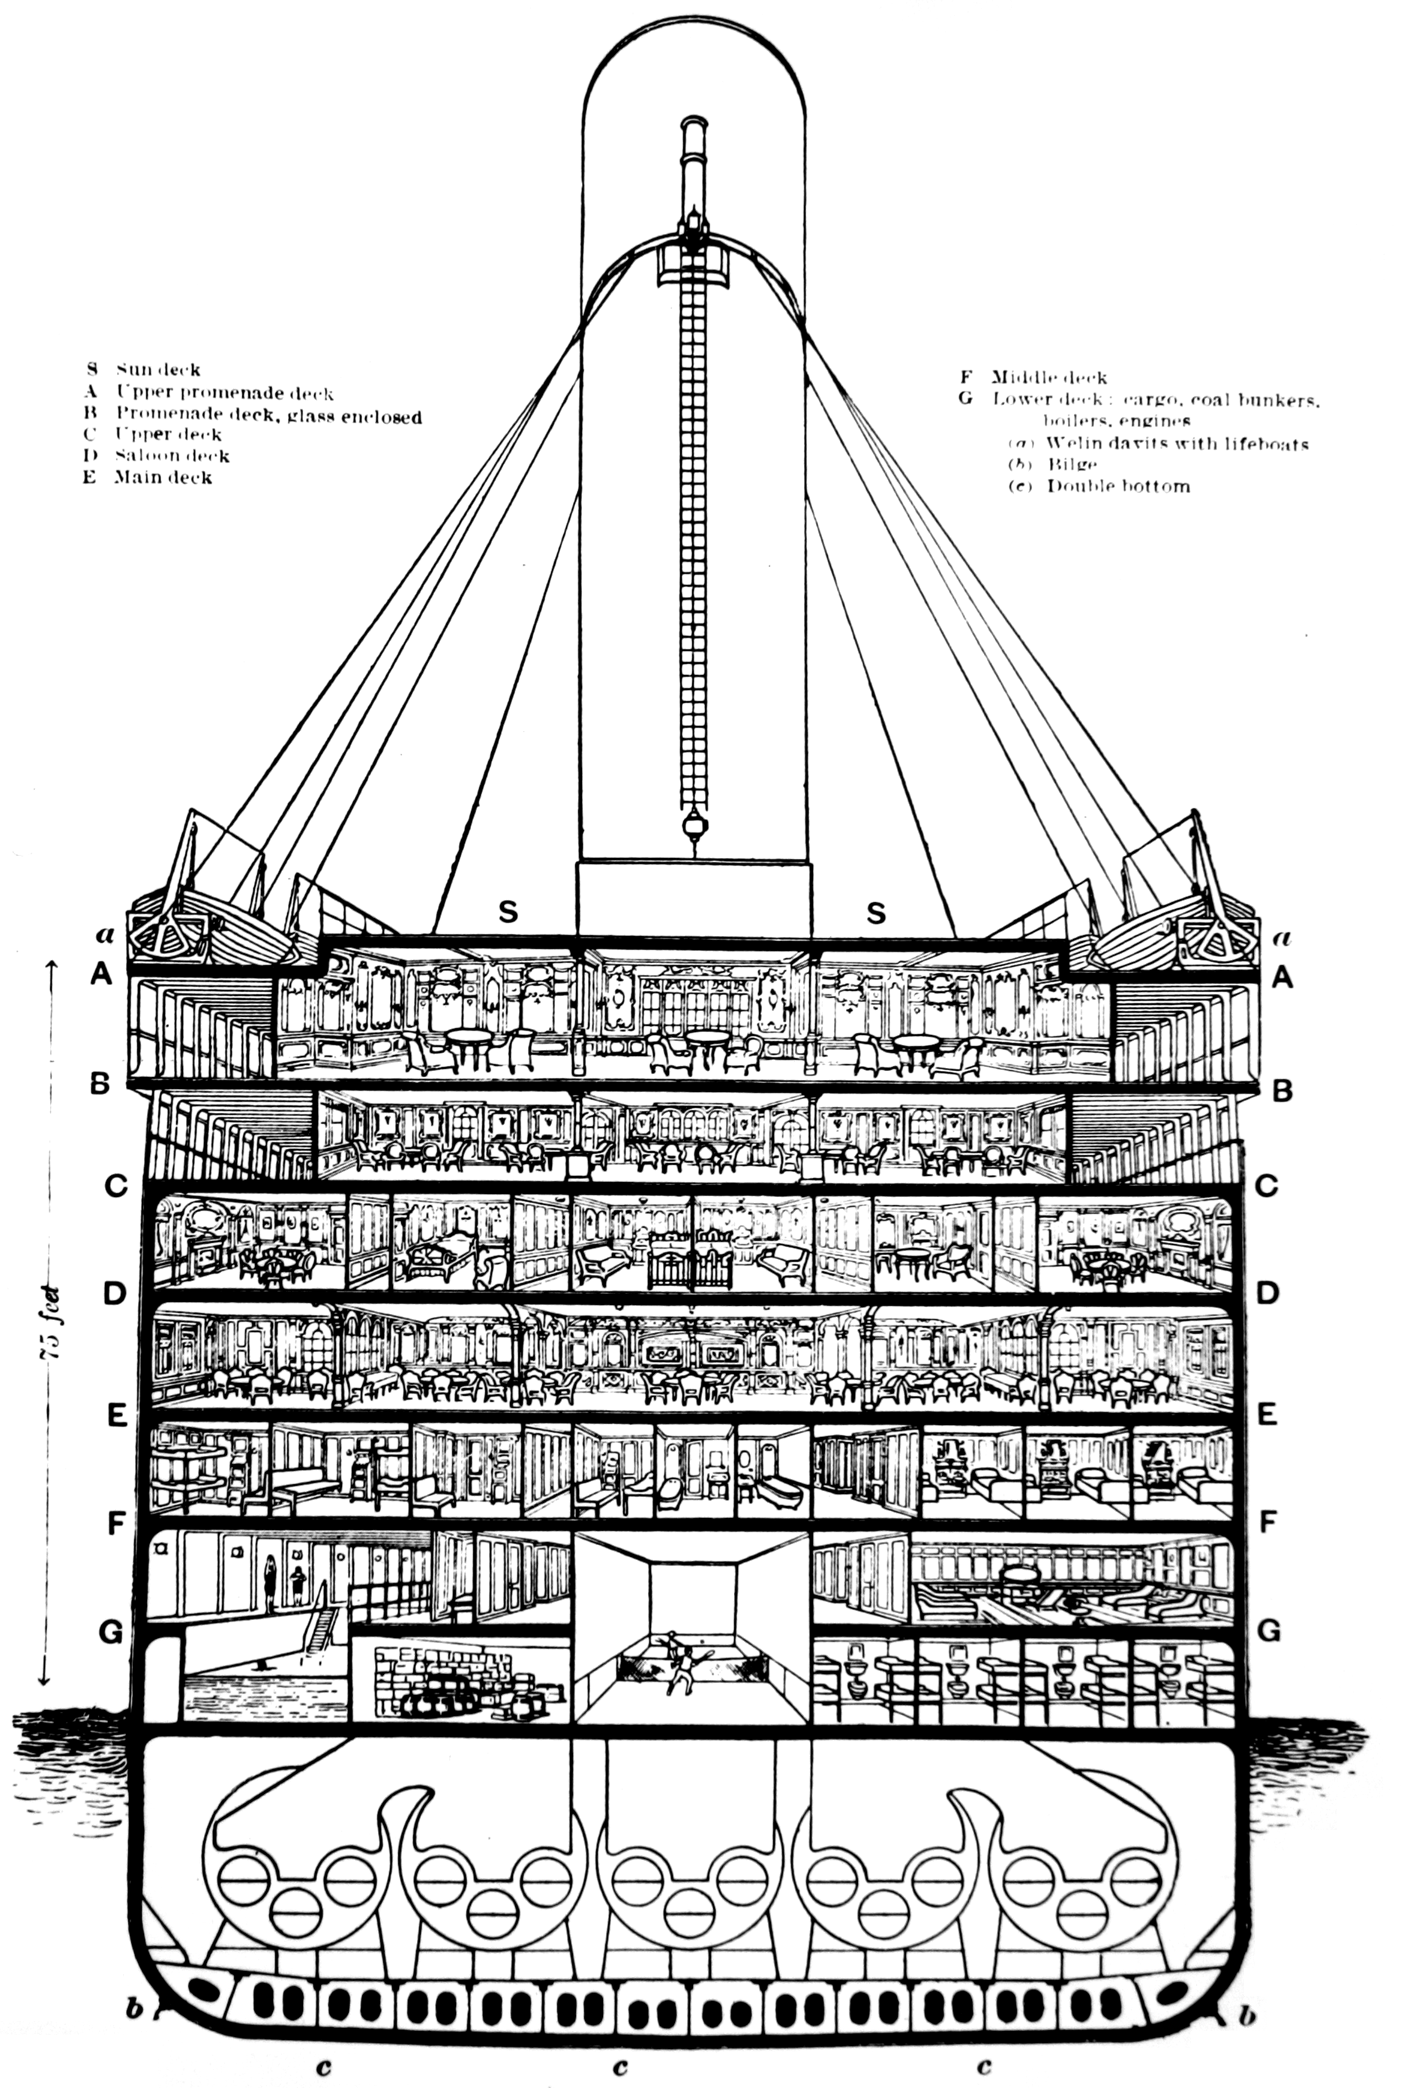

### Análisis preliminar 🕵️

**Voy e eliminar las columnas que no necesito.**

Para esto, primero creo una copia del dataframe original para no manipular los datos reales.

In [31]:
df = df_main.copy()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Elimino las columnas que no son de utilidad para el análisis, como lo son las columnas `Ticket`, `PassengerId` y `Cabin` (que tiene mas del 70% de los valores nulos).

In [32]:
# Muestro que procentaje de faltantes tiene cada columna
df.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

Aunque la columna `Cabin` me podria ser de gran ayuda, decido eliminarla por su gran cantidad de datos faltantes. Podria hacer un *web scraping* para conseguir los datos faltantes, pero creo que lleva su debido tiempo y no vale la pena.

In [34]:
df = df.drop(['Ticket', 'Cabin'], axis = 1)

In [35]:
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
518,519,1,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,26.00,S
208,209,1,3,"Carr, Miss. Helen ""Ellen""",female,16.0,0,0,7.75,Q
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,263.00,S


### Graficos 📊

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Grafico para mostrar en porcentaje y cantidad, las personas que sobrevivieron y las que no, agrupado por sexo.

<Figure size 300x300 with 0 Axes>

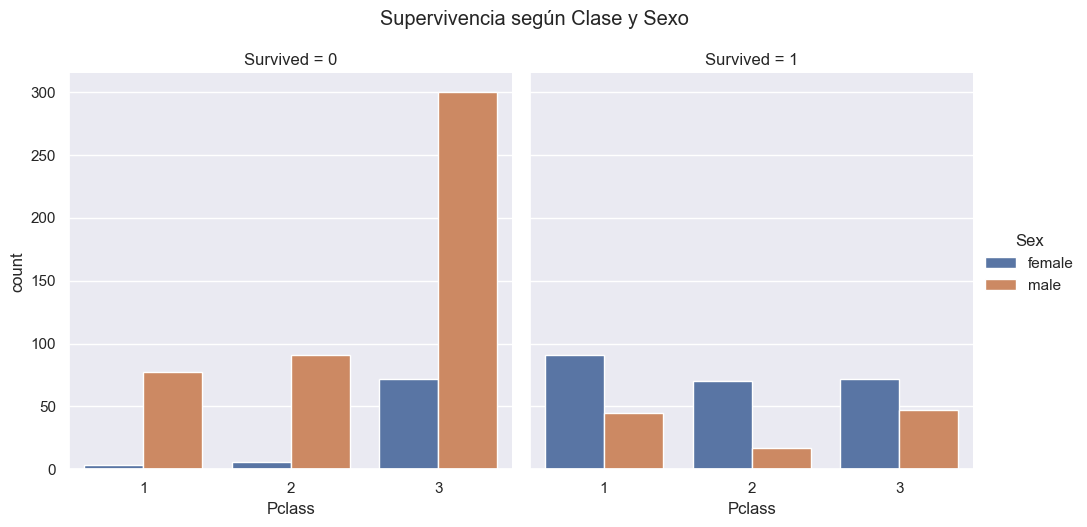

In [62]:
plt.figure(figsize=(3, 3))
sns.catplot(data=df, x='Pclass', hue='Sex', col='Survived', kind='count')
plt.suptitle('Supervivencia según Clase y Sexo', y=1.05)
plt.show()

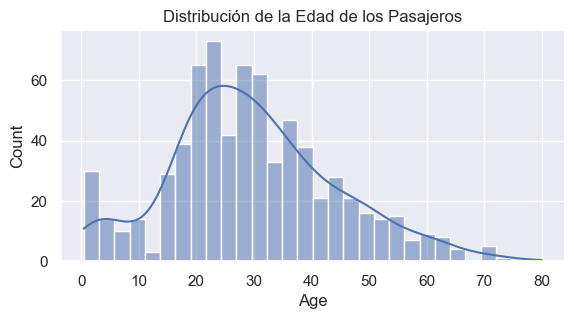

In [54]:
plt.figure(figsize=(6.5, 3))
sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title('Distribución de la Edad de los Pasajeros')
plt.show()

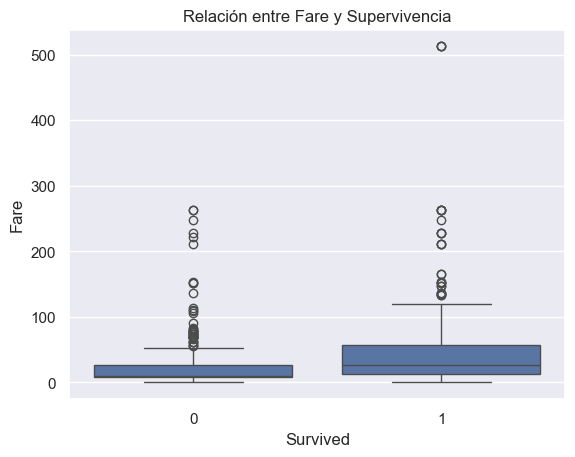

In [55]:
sns.boxplot(data=df, x='Survived', y='Fare')
plt.title('Relación entre Fare y Supervivencia')
plt.show()

In [58]:
df.loc[:, 'FamilySize'] = df.SibSp + df.Parch

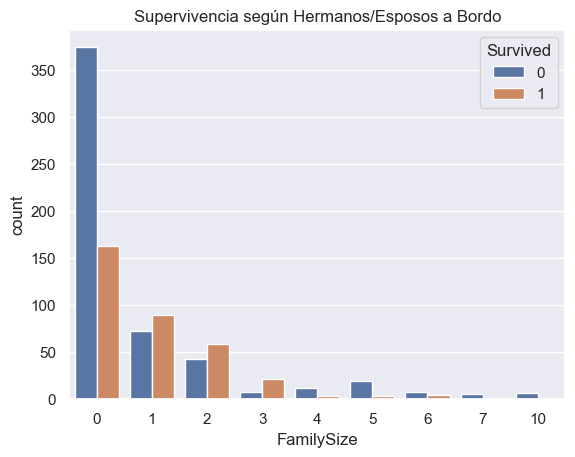

In [59]:
sns.countplot(data=df, x='FamilySize', hue='Survived')
plt.title('Supervivencia según Hermanos/Esposos a Bordo')
plt.show()

---
### Feature Engenieering (Ingenieria de variables ⚙️

Ahora necesito convertir a valores numericos las columans que son caracteres "strings", por lo tanto utilizo la funcion de pandas `get_dummies`.

In [7]:
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.sample(3)

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
725,726,0,"Oreskovic, Mr. Luka",20.0,0,0,8.6625,1,False,True,False,False,True,False,False,True
857,858,1,"Daly, Mr. Peter Denis",51.0,0,0,26.5500,1,False,True,True,False,False,False,False,True
540,541,1,"Crosby, Miss. Harriet R",36.0,0,2,71.0000,3,True,False,True,False,False,False,False,True


Ahora, para aprovechar la información que contiene la columna `Name`, lo que me interesa saber es que pronombre o titulo lleva cada pasajero. Con eso puedo saber no solo el rango etario de la persona, sino tambien su clase social por ejemplo.

Empiezo por averiguar cual es la mediana de la columna `Age` *(edad)* de los titulos mas representativos en el dataset.

In [8]:
medianAge_Mr = df.loc[df.Name.str.contains('Mr.')].Age.median()
medianAge_Mrs = df.loc[df.Name.str.contains('Mrs.')].Age.median()
medianAge_Miss = df.loc[df.Name.str.contains('Miss')].Age.median()
medianAge_Master = df.loc[df.Name.str.contains('Master')].Age.median()

print(medianAge_Mr)
print(medianAge_Mrs)
print(medianAge_Miss)
print(medianAge_Master)

31.0
35.0
21.0
3.5


Extraigo el titulo de cada pasajero, creando la columna `Title` para guardar estos resultados.

In [9]:
df.loc[:, 'Title'] = df.Name.str.extract(r' ([A-Za-z]+)\.')
df[['Name', 'Title']].sample(5)

,Name,Title
533,"Peter, Mrs. Catherine (Catherine Rizk)",Mrs
844,"Culumovic, Mr. Jeso",Mr
586,"Jarvis, Mr. John Denzil",Mr
116,"Connors, Mr. Patrick",Mr
199,"Yrois, Miss. Henriette (""Mrs Harbeck"")",Miss


En el codigo a continuación, lo que busco hacer es ver de cada titulo en el nombre, cuantos sobrevivieron y cuantos no pudieron.

In [10]:
test = df.copy()
test['Died'] = test.Survived.apply(lambda x: 1 if x == 0 else 0)

survidedByTitle = test[['Title','Survived', 'Died']].groupby('Title').sum().reset_index()
survidedByTitle['Total'] = survidedByTitle.Survived + survidedByTitle.Died

survidedByTitle


,Title,Survived,Died,Total
0,Capt,0,1,1
1,Col,1,1,2
2,Countess,1,0,1
3,Don,0,1,1
4,Dr,3,4,7
5,Jonkheer,0,1,1
6,Lady,1,0,1
7,Major,1,1,2
8,Master,23,17,40
9,Miss,127,55,182


<Axes: xlabel='Title', ylabel='Total'>

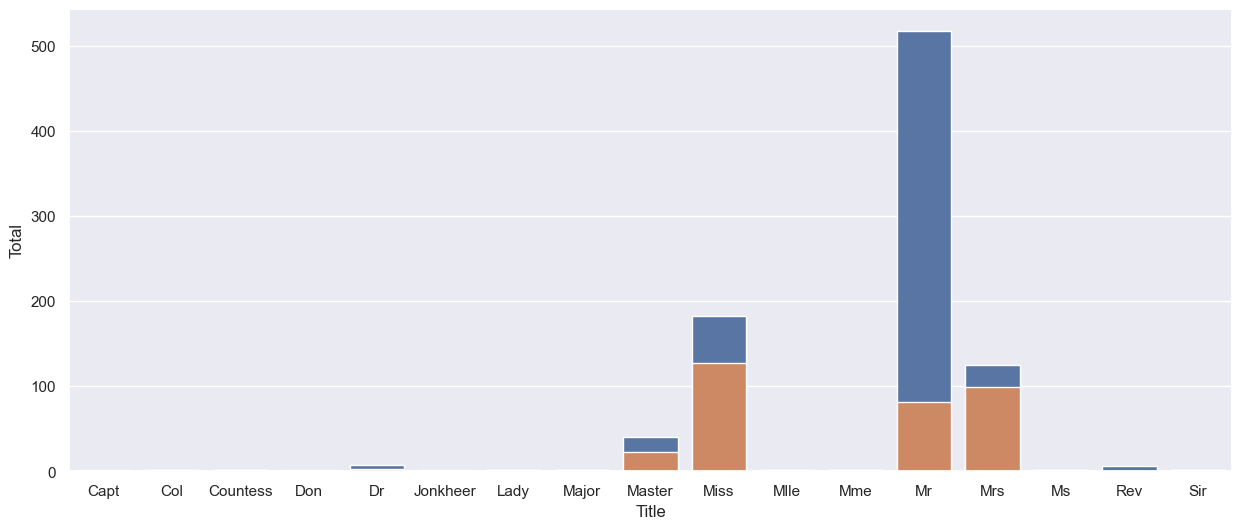

In [11]:
plt.figure(figsize=(15, 6))
sns.barplot(x = survidedByTitle.Title, y = survidedByTitle.Total)
sns.barplot(x = survidedByTitle.Title, y = survidedByTitle.Survived)

Finalmente, necesito tener todos mis datos en valores numericos, entonces empiezo a eliminar las columans con valores con letras.

In [12]:
df_num = df.drop(['Name'], axis = 1)
df_num.isna().sum()

PassengerId      0
Survived         0
Age            177
SibSp            0
Parch            0
Fare             0
FamilySize       0
Sex_female       0
Sex_male         0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Title            0
dtype: int64

Aprovechando la columna de `Age_wiki` del dataset extendido, quiero asignar a los pasajeros que tienen la edad como valor vacio, los valores de las edades sacadas de wikipedia. Para eso, hago un *merge* entre ambos dataframes y asi conecto las columnas.

In [13]:
# A los registros que tienen nulos en la columna Age, le asigno el valor de Age_wiki
df_num = df_num.merge(df_ext[['PassengerId', 'Age_wiki']], how = 'outer', on = 'PassengerId')
df_num.Age = df_num.Age.fillna(df_num.Age_wiki)
df_num.isna().sum()

PassengerId    0
Survived       0
Age            4
SibSp          0
Parch          0
Fare           0
FamilySize     0
Sex_female     0
Sex_male       0
Pclass_1       0
Pclass_2       0
Pclass_3       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
Title          0
Age_wiki       4
dtype: int64

Como noto que quedan cuatro registros con los valores de edad como nulos, decido imputarle los valores de la mediana de la columna `Age`

In [14]:
df_num.loc[df_num.Age.isna()]

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title,Age_wiki
42,43,0,NaN,0,0,7.8958,1,False,True,False,False,True,True,False,False,Mr,NaN
347,348,1,NaN,1,0,16.1000,2,True,False,False,False,True,False,False,True,Mrs,NaN
420,421,0,NaN,0,0,7.8958,1,False,True,False,False,True,True,False,False,Mr,NaN
557,558,0,NaN,0,0,227.5250,1,False,True,True,False,False,True,False,False,Mr,NaN


In [15]:
indexes = df_num.loc[df_num.Age.isna()].index
df_num.loc[indexes, 'Age'] = df_num.Age.median()

In [16]:
df_num.loc[df_num.Age.isna()]

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title,Age_wiki


Finalmente, convierto todos los valores a flotantes, y con esto, ya puedo hacer una matriz de correlación para explorar las relaciones que existen entre las columns del datasets.

In [17]:
titulos_frecuentes = df_num.Title.value_counts().reset_index().Title[:4].values

df_num_cortado = pd.get_dummies(df_num[df_num['Title'].isin(titulos_frecuentes)], ['Title'])
df_num_cortado.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_wiki,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0,22.0,1,0,7.2500,2,False,True,False,False,True,False,False,True,22.0,False,False,True,False
1,2,1,38.0,1,0,71.2833,2,True,False,True,False,False,True,False,False,35.0,False,False,False,True
2,3,1,26.0,0,0,7.9250,1,True,False,False,False,True,False,False,True,26.0,False,True,False,False
3,4,1,35.0,1,0,53.1000,2,True,False,True,False,False,False,False,True,35.0,False,False,False,True
4,5,0,35.0,0,0,8.0500,1,False,True,False,False,True,False,False,True,35.0,False,False,True,False


In [18]:
df_num = pd.merge(df_num, df_num_cortado)

In [19]:
df_num = df_num.drop(['Age_wiki', 'Title', 'PassengerId'], axis = 1).astype(float)
df_num.head()

,Survived,Age,SibSp,Parch,Fare,FamilySize,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0.0,22.0,1.0,0.0,7.2500,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,38.0,1.0,0.0,71.2833,2.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,26.0,0.0,0.0,7.9250,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,35.0,1.0,0.0,53.1000,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,35.0,0.0,0.0,8.0500,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [20]:
df_num.to_csv('../datasets/train-limpio.csv', index = False)

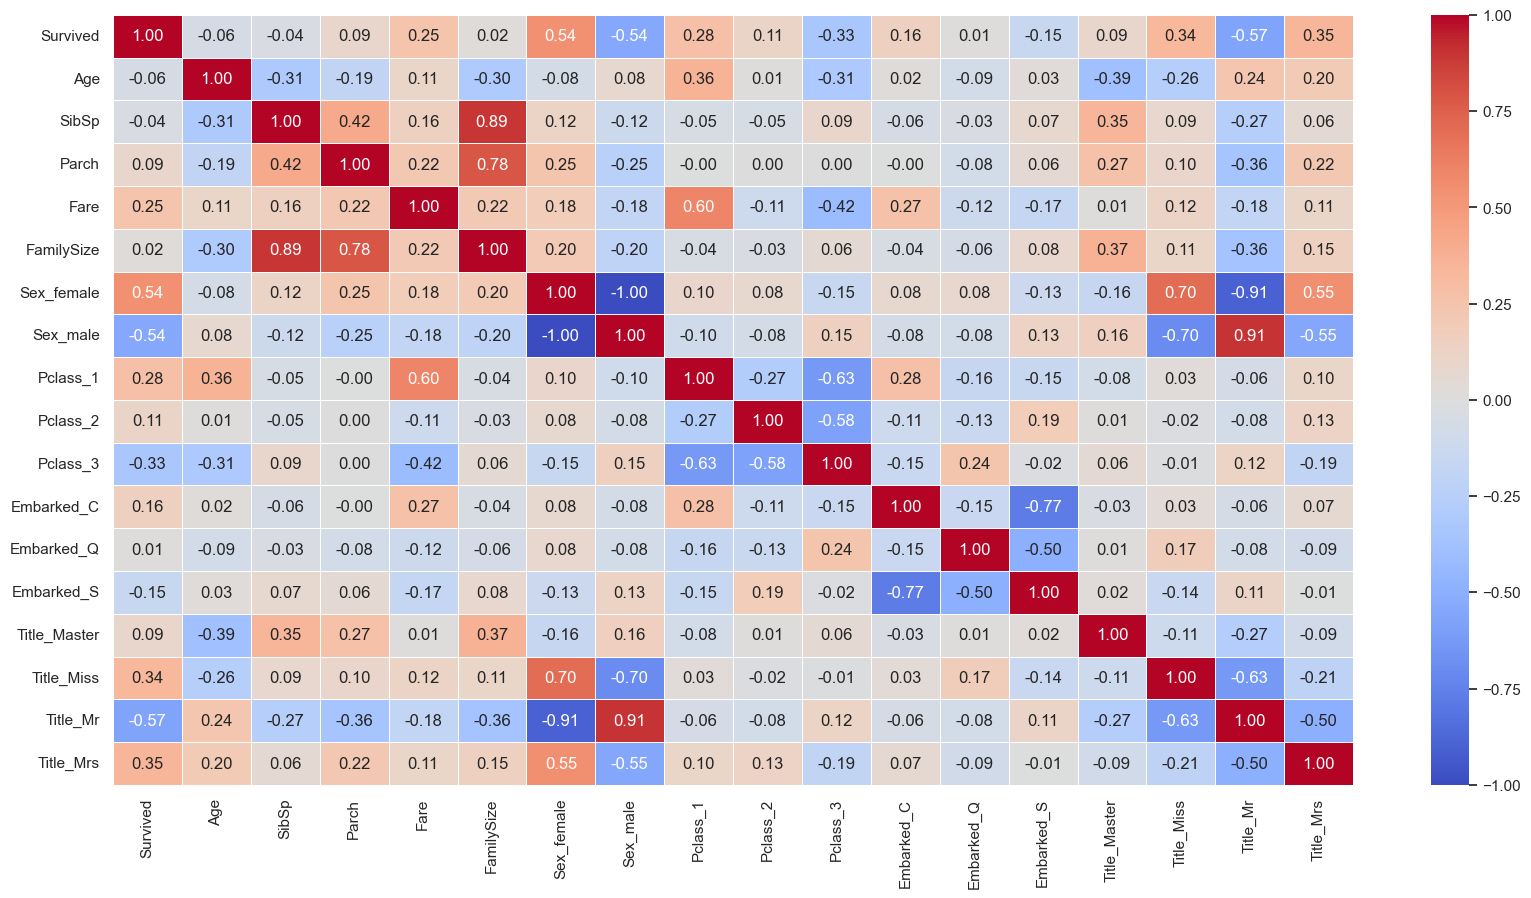

In [21]:
correlacion = df_num[df_num.describe().columns].corr()

plt.figure(figsize=(20, 10))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

### **Data en internet**

Cabinas por pasajero: https://www.encyclopedia-titanica.org/cabins.html

Pasajeros por clase: https://titanicfacts.net/titanic-passenger-list/